# 2019 Canadian Election tweets
# OSEMN Step 3: Explore
# Explore Sentiment 140 dataset

This notebook describes part of Step 3: Explore of OSEMN methodology. It covers cleanup of Sentiment 140.

## Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud
from time import time

sns.set()

In [2]:
from src.proc_utils import string_concat, duplicate_check, tfm_2class

In [3]:
data_dir = '../../data/sentiment140/'
os.listdir(data_dir)

['sentiment140_train_cleaned.csv',
 'sentiment140_train_nodup.csv',
 'testdata.manual.2009.06.14.csv',
 'training.1600000.processed.noemoticon.csv']

## Load cleaned Sentiment 140 dataset

In [4]:
t = time()
df = pd.read_csv(data_dir + 'sentiment140_train_cleaned.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)


----- DataFrame loaded
in 3.65 seconds
with 1,599,306 rows
and 8 columns
-- Column names:
 Index(['sentiment', 'ids', 'date', 'query', 'user', 'text', 'hashtags',
       'handles'],
      dtype='object')


## Count of tweets per class

In [5]:
df['sentiment'].value_counts()


0    799801
4    799505
Name: sentiment, dtype: int64

## Word clouds
Word clouds are produced separately for negative and positive tweets

First 500 symbols in the  string:

@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah! @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds my whole body feels itchy and like its on fire  @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.  @Kwesidei not the whole crew  Need a hug  @LOL


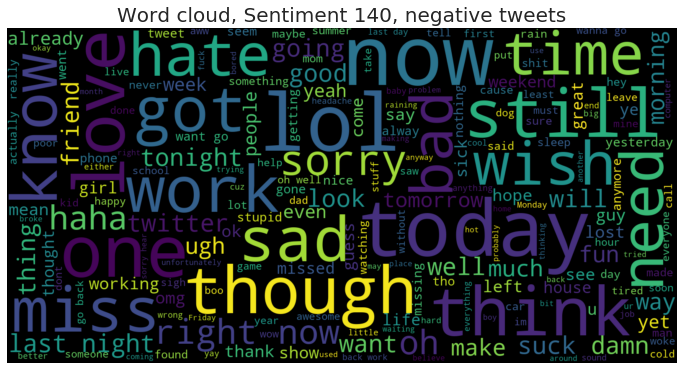

In [6]:
neg_tweets = df[df['sentiment'] == 0]
neg_string = string_concat(neg_tweets['text'])

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, 
                      colormap='viridis').generate(neg_string)

f, ax = plt.subplots(1, figsize=(12,10))
ax.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax.set_title("Word cloud, Sentiment 140, negative tweets", fontsize=20)
f.savefig('results/wordcloud_sentiment140_neg.png')

First 500 symbols in the  string:

I LOVE @Health4UandPets u guys r the best!!  im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!! @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.  Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup @LovesBrooklyn2 he has that effect on everyone  @ProductOfFear You can tell him that I just burst out laughing really loud because of that 


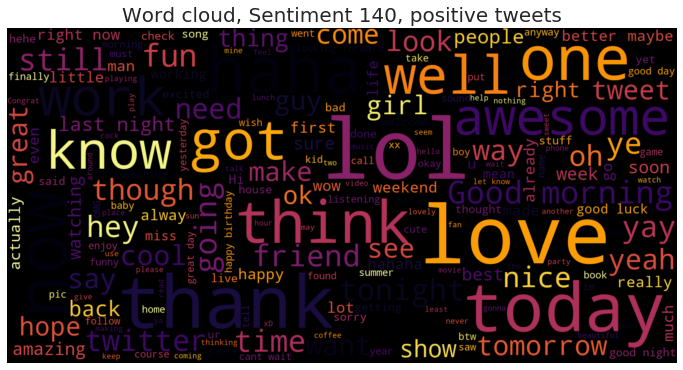

In [7]:
pos_tweets = df[df['sentiment'] == 4]
pos_string = string_concat(pos_tweets['text'])

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, 
                      colormap='inferno').generate(pos_string)

f, ax = plt.subplots(1, figsize=(12,10))
ax.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax.set_title("Word cloud, Sentiment 140, positive tweets", fontsize=20)
f.savefig('results/wordcloud_sentiment140_pos.png')

## Most frequent hashtags

In [8]:
# concatenate hashtags from all tweets together, convert to lower case, split by ' ', save to a pandas Series 
all_hashtags_se = pd.Series(df['hashtags'].str.cat(sep=" ").lower().split())

print("Top 10 hashtags by frequency:\n")
print(all_hashtags_se.value_counts().head(10))

Top 10 hashtags by frequency:

#followfriday    2639
#fb              1786
#ff               985
#squarespace      941
#1                517
#iranelection     516
#seb              499
#musicmonday      422
#fail             363
#2                341
dtype: int64


## Most frequent user handles

In [9]:
# concatenate hashtags from all tweets together, convert to lower case, split by ' ', save to a pandas Series 
all_handles_se = pd.Series(df['handles'].str.cat(sep=" ").lower().split())

print("Top 10 user handles by frequency:\n")
print(all_handles_se.value_counts().head(10))

Top 10 user handles by frequency:

@mileycyrus         4579
@tommcfly           3902
@ddlovato           3473
@jonasbrothers      2384
@davidarchie        1386
@donniewahlberg     1330
@jonathanrknight    1266
@jordanknight       1150
@mitchelmusso       1103
@taylorswift13      1027
dtype: int64


## Length of tweets

In [10]:
t = time()
# add a new column with length of strings in 'text' to the DataFrame with generic tweets
df['text_len'] = df['text'].str.len()
elapsed = time() - t
print("Column 'text_len' was added to the DataFrame. Took {0:,.2f} seconds ({1:,.2f} minutes)"
      .format(elapsed, elapsed / 60))

Column 'text_len' was added to the DataFrame. Took 0.64 seconds (0.01 minutes)


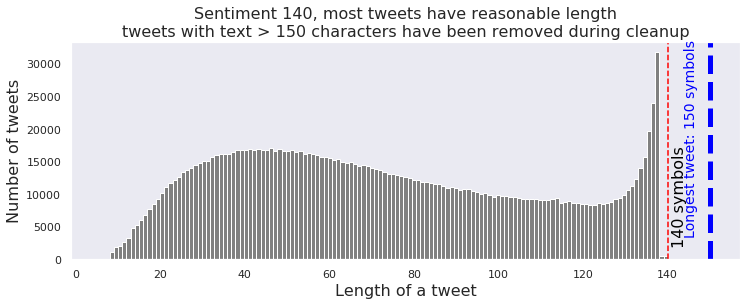

In [11]:
# plot histogram of values
# create figure and axis
f, ax = plt.subplots(1, figsize=(12, 4))

# plot a histogram of 'text_len'
df['text_len'].hist(bins=145, color='gray')

# draw supplementary lines -- 140 symbols, longest tweet in the dataset
font = {'size': 16}
ax.axvline(140, color='red', linestyle='--', )
ax.text(141, 
        2300, 
        "140 symbols", 
        rotation=90, 
        color='black', 
        fontdict=font)

ax.axvline(df['text_len'].max(), color='blue', linestyle='--', linewidth=5)
ax.text(df['text_len'].max() * 0.96, 
        3900, 
        "Longest tweet: {0} symbols".format(df['text_len'].max()), 
        rotation=90, 
        color='blue', 
        fontdict={'size': 14})

# set axis parameters
ax.set_title("Sentiment 140, most tweets have reasonable length"
             "\ntweets with text > 150 characters have been removed during cleanup", 
             fontdict=font)
ax.set_xlabel("Length of a tweet", fontdict=font)
ax.set_ylabel("Number of tweets", fontdict=font)
ax.grid(False)
f.savefig('results/textlen_sentiment140.png', bbox_inches='tight')

## Term Frequency Matrix

### Document frequency limits: min=0.0, max=0.9

In [12]:
min_df = 0.0
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)

Number of tokens in vocabulary
when using 'min_df'=0.0 and 'max_df'=0.9:
619403


,neg_tf,pos_tf,total,abs_diff
love,20504,54981,75485,34477
good,29205,62114,91319,32909
thanks,5800,34514,40314,28714
sad,27917,1509,29426,26408
work,45454,19544,64998,25910
...,...,...,...,...
ncrystean,1,1,2,0
cooing,4,4,8,0
fiannan,1,1,2,0
kuu,1,1,2,0


### Document frequency limits: min=0.01, max=0.9

In [13]:
min_df = 0.01
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)

Number of tokens in vocabulary
when using 'min_df'=0.01 and 'max_df'=0.9:
74


,neg_tf,pos_tf,total,abs_diff
love,20504,54981,75485,34477
good,29205,62114,91319,32909
thanks,5800,34514,40314,28714
sad,27917,1509,29426,26408
work,45454,19544,64998,25910
...,...,...,...,...
weekend,8913,9588,18501,675
know,26306,25730,52036,576
make,12310,12656,24966,346
little,8381,8569,16950,188


### Document frequency limits: min=0.03, max=0.9

In [14]:
min_df = 0.03
max_df = 0.9

tfm = tfm_2class(df, 'sentiment', 
                 [0, 4], 'text', 
                 min_df=min_df, max_df=max_df)

print("Number of tokens in vocabulary")
print("when using 'min_df'={0} and 'max_df'={1}:"
      .format(min_df, max_df))
print(len(tfm))

tfm.sort_values('abs_diff', ascending=False)


Number of tokens in vocabulary
when using 'min_df'=0.03 and 'max_df'=0.9:
13


,neg_tf,pos_tf,total,abs_diff
love,20504,54981,75485,34477
good,29205,62114,91319,32909
work,45454,19544,64998,25910
don,32895,17236,50131,15659
lol,23126,36130,59256,13004
today,38114,30089,68203,8025
day,39852,47183,87035,7331
got,33286,28004,61290,5282
like,41041,37514,78555,3527
time,27516,30420,57936,2904
